In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader

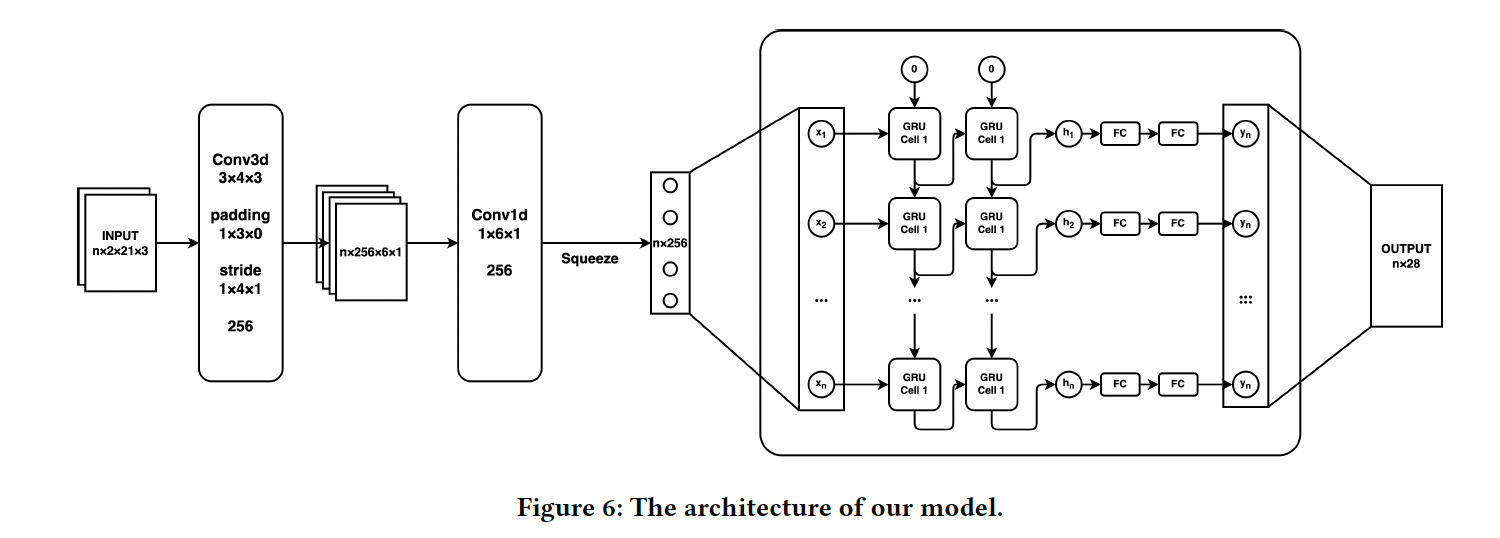


In [118]:
b = 1 # batch size
n = 2 # window size 
output_size = 5 # number of characters
input = torch.randn(2, n, 21, 3)

# Input shape: (Batch size, in_channels, Depth, Height, Witdth)
conv3D_1 = nn.Conv3d(in_channels=2, out_channels=256, kernel_size=(3, 4, 3), padding=(1, 3, 0), stride=(1, 4, 1))
output = conv3D_1(input) # n x 256 x 6 x 1 = 30 x 256 x 6 x 1
print("1st CNN:", output.shape)
conv3D_2 = nn.Conv3d(in_channels=256, out_channels=256, kernel_size=(1, 6, 1), padding=0, stride=1)
output = conv3D_2(output)
print("2nd CNN:", output.shape)
# torch.Size([1, 256, 5, 6, 1]) . Expected N x 256 x 6 x 1 => 5 x 256 x 6 x 1
output = output.view(n, -1)
print("Reshape for GRU:", output.shape)

# 2 GRU layers.
hidden_size = 256
gru = nn.GRU(input_size=256, hidden_size=hidden_size, batch_first=True, num_layers=2)
output, _ = gru(output)
print("After GRU output:", output.shape)

# Fully connected layers
fc1 = nn.Linear(hidden_size, hidden_size)
fc2 = nn.Linear(hidden_size, output_size)

output = fc2(fc1(output))
softmax = nn.Softmax(dim=1)
output = softmax(output)
print("After 2 conv layers output:", output.shape)
print('output: ', output)

1st CNN: torch.Size([256, 2, 6, 1])
2nd CNN: torch.Size([256, 2, 1, 1])
Reshape for GRU: torch.Size([2, 256])
After GRU output: torch.Size([2, 256])
After 2 conv layers output: torch.Size([2, 5])
output:  tensor([[0.2128, 0.1818, 0.2032, 0.1983, 0.2039],
        [0.2140, 0.1807, 0.2021, 0.1998, 0.2034]], grad_fn=<SoftmaxBackward0>)


MSE loss

In [119]:
i = np.random.randint(0, output_size)
target = torch.zeros(output_size)
target[i] = 1
loss = nn.MSELoss()
input = output[0][1]

print(loss(input, target))

tensor(0.1603, grad_fn=<MseLossBackward0>)


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Cross entropy loss

In [121]:
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
print('input: ', input)
target = torch.randn(3, 5).softmax(dim=1)
print('target: ', target)
output = loss(input, target)
print('output: ', output)


input:  tensor([[ 1.6178,  0.8742, -0.4039,  0.3786,  0.5115],
        [ 1.9489,  0.1880,  0.6964,  1.6743,  0.3517],
        [-0.2736, -0.4102,  1.2165, -0.5900, -0.5798]], requires_grad=True)
target:  tensor([[0.0166, 0.1459, 0.2954, 0.0897, 0.4524],
        [0.2729, 0.0219, 0.0827, 0.0604, 0.5621],
        [0.1216, 0.2234, 0.5226, 0.0442, 0.0882]])
output:  tensor(1.8008, grad_fn=<DivBackward1>)


## RCNN

In [16]:
class RCNN(nn.Module):
    def __init__(self, cnn_output_size, in_channels, hidden_size, output_size):
        super().__init__()
        # CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->
        self.cnn_output_size = cnn_output_size
        self.in_channels = in_channels
        # Input shape: (Batch size, in_channels, Depth, Height, Witdth)
        self.conv3D_1 = nn.Conv3d(in_channels=in_channels, out_channels=cnn_output_size, kernel_size=(3, 4, 3), padding=(1, 3, 0), stride=(1, 4, 1))
        self.bn_1 = nn.BatchNorm3d(cnn_output_size)
        
        self.dropout_1 = nn.Dropout3d(p=0.2)
        
        self.conv3D_2 = nn.Conv3d(in_channels=cnn_output_size, out_channels=cnn_output_size, kernel_size=(1, 6, 1), padding=0, stride=1)
        self.bn_2 = nn.BatchNorm3d(cnn_output_size)
        self.dropout_2 = nn.Dropout3d(p=0.2)
        self.gru = nn.GRU(input_size=cnn_output_size, hidden_size=hidden_size, batch_first=True, num_layers=2)
        
        self.fc1 = nn.Linear(hidden_size, hidden_size)

        self.bn_3 = nn.BatchNorm1d(hidden_size)
        self.dropout_3 = nn.Dropout1d(p=0.2)

        self.fc2 = nn.Linear(hidden_size, output_size)

        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
       
        x = self.dropout_1(F.sigmoid(self.bn_1(self.conv3D_1(x)))) # n x 256 x 6 x 1 = 30 x 256 x 6 x 1
        
        x = self.dropout_2(F.sigmoid(self.bn_2(self.conv3D_2(x))))
        # print("After 2 conv:", x.size())
        x = x.squeeze().mT

        # print("After squeezing for GRU:", x.size())
        x, _ = self.gru(x)
        
        # print("After GRU:", x.size())

        x = torch.stack([self.dropout_3(
            F.sigmoid(
                self.fc1(
                    self.bn_3(frame)))) for frame in x])

        # print("After first FC:", x.size())
        #x = self.fc1(x) 
        
        x = torch.stack([F.softmax(self.fc2(frame), dim=-1) for frame in x])
        # print("After 2nd FC:", x.size())
        return x

In [435]:
window_size = 5
cnn_output_size = 256
in_channels = 2
hidden_size = 256
output_size = 28

model = RCNN(window_size, cnn_output_size, in_channels, hidden_size, output_size)
input = torch.randn(64, 2, window_size, 21, 3)
model(input)

tensor([[[0.0415, 0.0468, 0.0235,  ..., 0.0274, 0.0438, 0.0340],
         [0.0351, 0.0364, 0.0368,  ..., 0.0380, 0.0382, 0.0347],
         [0.0562, 0.0398, 0.0256,  ..., 0.0323, 0.0358, 0.0319],
         [0.0545, 0.0409, 0.0255,  ..., 0.0313, 0.0366, 0.0296],
         [0.0643, 0.0454, 0.0257,  ..., 0.0342, 0.0375, 0.0291]],

        [[0.0406, 0.0472, 0.0256,  ..., 0.0267, 0.0371, 0.0281],
         [0.0351, 0.0364, 0.0368,  ..., 0.0380, 0.0382, 0.0347],
         [0.0351, 0.0364, 0.0368,  ..., 0.0380, 0.0382, 0.0347],
         [0.0603, 0.0431, 0.0258,  ..., 0.0305, 0.0410, 0.0306],
         [0.0543, 0.0373, 0.0269,  ..., 0.0342, 0.0359, 0.0325]],

        [[0.0385, 0.0449, 0.0252,  ..., 0.0245, 0.0421, 0.0301],
         [0.0477, 0.0436, 0.0235,  ..., 0.0251, 0.0440, 0.0328],
         [0.0492, 0.0437, 0.0239,  ..., 0.0307, 0.0376, 0.0314],
         [0.0637, 0.0422, 0.0265,  ..., 0.0347, 0.0363, 0.0333],
         [0.0661, 0.0393, 0.0257,  ..., 0.0390, 0.0349, 0.0334]],

        ...,

     

In [44]:
import pandas as pd
from torch.utils.data import Dataset, ConcatDataset
alphabet = np.array(['[i]','[s]', 'BackSpace', ',', '.',
                     'a', 'b', 'c', 'd', 'e', 'f', 
                     'g', 'h', 'i', 'j', 'k', 'l', 
                     'm', 'n', 'o', 'p', 'q', 'r', 
                     's', 't', 'u', 'v', 'w', 'x', 
                     'y', 'z'])
def one_hot_encoder(char):
    if char not in alphabet:
        index = 0  # Return None if the character is not in the alphabet
    else:
        index = np.where(alphabet == char)[0]
    one_hot = np.zeros(len(alphabet))
    one_hot[index] = 1
    return one_hot


class KeyStrokeDataset(Dataset):
    def __init__(self, video_name, s=5, window_size=128, step_size=64):
        self.img_labels = pd.read_csv(f"./labels/{video_name}.csv", header=0)
        self.landmarks  = np.load(f'./videos/{video_name}.npy')
        self.window_size = window_size
        self.step_size = step_size
        self.s = s
        self.label_smoothing()

        self.class_count = []

        for key in alphabet:
            self.class_count.append(len(self.img_labels.loc[self.img_labels['Key'] == key]))
        print('self.class_count: ', self.class_count)
       
        
        # idle state
        self.class_count[0] = self.landmarks.shape[0] - np.sum(self.class_count)
        # print("Landmark size:", self.landmarks.shape)
    
    def label_smoothing(self):
        labels = []
        non_idle_frames = []
        num_frames = len(self.landmarks)
       
        
        for i in range(num_frames):
            one_hot = []
            frame_label = self.img_labels.loc[self.img_labels['Frame'] == i]['Key']
            
            if len(frame_label) == 1:
                one_hot = one_hot_encoder(frame_label.iloc[0])
                non_idle_frames.append(i)
            else: 
                one_hot = one_hot_encoder('Idle')
            
            labels.append(one_hot)
        self.raw_labels = torch.from_numpy(np.array(labels))
        self.labels = torch.from_numpy(np.array(labels))
        
        s = self.s # Smooth window size s
        
        for idx, curr_frame  in enumerate(non_idle_frames):
            curr_label = self.labels[curr_frame]
            
            # smooth frames before
            max_frame_before = curr_frame - s if (curr_frame - s) >= 0 else 0
            # Overlap
            if (idx > 0): 
                prev_non_idle_frame = non_idle_frames[idx - 1]
                
                if max_frame_before <= prev_non_idle_frame:
                    max_frame_before = curr_frame - s // 3
            
            
            
            for n in range(max_frame_before, curr_frame, 1):
                self.labels[n] = curr_label

            # smooth frames after
            max_frame_after = curr_frame + s if (curr_frame + s) < num_frames else num_frames - 1
            # Overlap
            if (idx < len(non_idle_frames) - 1): 
                next_non_idle_frame = non_idle_frames[idx + 1]
                
                if max_frame_after >= next_non_idle_frame:

                    max_frame_after = curr_frame + s // 3
            
            for m in range(curr_frame + 1, max_frame_after + 1, 1):
                self.labels[m] = curr_label

    def __len__(self):
        total_frames = self.landmarks.shape[0]
        total_windows = (total_frames - self.window_size) // self.step_size + 1
        return total_windows
    # def get_label_weight():
        
    def __getitem__(self, idx):
        start_frame = idx * self.step_size
        
        end_frame = idx * self.step_size + self.window_size - 1
        # print('end_frame: ', end_frame)
        left = []
        right = []
        for l in self.landmarks[start_frame: end_frame+1]:
            left.append(l[0])
            right.append(l[1])
        labels = []
        for i in range(start_frame,end_frame+1):
            one_hot = []
            frame_label = self.img_labels.loc[self.img_labels['Frame'] == i]['Key']
            
            if len(frame_label) == 1:
                one_hot = one_hot_encoder(frame_label.iloc[0])
                
            else: 
                one_hot = one_hot_encoder('Idle')

            labels.append(one_hot)

        window = torch.from_numpy(np.array([left, right])).float()
        labels = torch.from_numpy(np.array(self.labels[start_frame: end_frame+1])).float()
        return window, labels

In [45]:
videos = []
for video in ['video_1', 'video_2', 'video_3', 'video_4', 'video_5',
              'video_6', 'video_7', 'video_8', 'video_9', 'video_10',
              'video_11', 'video_12', 'video_13', 'video_14', 'video_15'
              , 'video_16']:
    data = KeyStrokeDataset(video)
    print(video, len(data))
    videos.append(data)

train_data = ConcatDataset(videos)

self.class_count:  [0, 68, 22, 2, 5, 24, 5, 10, 13, 43, 9, 6, 14, 18, 2, 2, 17, 8, 18, 32, 3, 1, 20, 13, 26, 11, 4, 4, 0, 9, 0]
video_1 51
self.class_count:  [0, 180, 51, 3, 12, 61, 19, 27, 37, 112, 17, 14, 33, 55, 6, 4, 39, 25, 47, 57, 13, 2, 50, 38, 80, 34, 9, 15, 1, 19, 0]
video_2 160
self.class_count:  [0, 208, 114, 11, 16, 82, 11, 54, 32, 142, 20, 32, 27, 87, 2, 10, 48, 22, 80, 70, 15, 3, 87, 56, 84, 29, 11, 11, 4, 23, 0]
video_3 225
self.class_count:  [0, 103, 36, 2, 7, 25, 9, 21, 13, 61, 13, 6, 17, 32, 1, 4, 27, 11, 27, 44, 8, 1, 29, 39, 34, 22, 2, 14, 0, 11, 1]
video_4 87
self.class_count:  [0, 65, 24, 1, 4, 16, 4, 5, 3, 35, 3, 7, 22, 24, 2, 2, 10, 8, 22, 29, 5, 0, 15, 17, 32, 8, 2, 12, 0, 4, 0]
video_5 50
self.class_count:  [0, 262, 139, 8, 27, 98, 18, 40, 36, 139, 17, 24, 52, 99, 3, 10, 47, 25, 84, 82, 35, 0, 69, 62, 94, 37, 10, 34, 4, 26, 1]
video_6 210
self.class_count:  [0, 153, 66, 8, 9, 61, 7, 20, 24, 79, 6, 12, 33, 62, 2, 8, 30, 19, 54, 45, 13, 0, 41, 23, 61, 14, 10, 16

In [60]:
counts = []
for data in videos:
    counts.append(data.class_count)
counts = np.array(counts)
counts.shape
total_counts = np.array(counts.sum(axis=0))
N = np.sum(total_counts)
number_of_class = len(alphabet)
weight = N / (number_of_class * total_counts)
print(f"Total frames: {N}")
print(f"Class distribution: \n{total_counts}")
print(f"Weight for loss function: \n {weight}")

Total frames: 205922
Class distribution: 
[182431   3830   1800    126    225   1397    259    575    637   2217
    356    331    789   1335     44    160    743    397   1252   1393
    393     23   1144   1044   1514    513    201    379     36    360
     18]
Weight for loss function: 
 [3.64118223e-02 1.73437210e+00 3.69035842e+00 5.27194060e+01
 2.95228674e+01 4.75493569e+00 2.56472786e+01 1.15524264e+01
 1.04280144e+01 2.99623147e+00 1.86591156e+01 2.00684144e+01
 8.41906865e+00 4.97576417e+00 1.50969208e+02 4.15165323e+01
 8.94030304e+00 1.67321037e+01 5.30562713e+00 4.76858949e+00
 1.69024050e+01 2.88810659e+02 5.80650801e+00 6.36268694e+00
 4.38748029e+00 1.29486260e+01 3.30479859e+01 1.75267682e+01
 1.84517921e+02 1.84517921e+01 3.69035842e+02]


In [62]:
cnn_output_size = 256
in_channels = 2
hidden_size = 256
output_size = len(alphabet)
window_size = 128
model = RCNN(cnn_output_size, in_channels, hidden_size, output_size)

batch_size = 64
learning_rate = 0.05
train_dataloader = DataLoader(train_data, batch_size=batch_size)

loss_fn = nn.CrossEntropyLoss(torch.from_numpy(weight).float())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # print('batch: ', batch)
        # Compute prediction and loss
        # X = X.view(-1, in_channels, window_size, 21, 3)
        pred = model(X)
        loss = loss_fn(pred.view(-1, output_size), torch.argmax(y, dim=-1).view(-1))
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % batch_size == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.432724  [   64/ 3194]
Epoch 2
-------------------------------
loss: 3.396669  [   64/ 3194]
Epoch 3
-------------------------------
loss: 3.402939  [   64/ 3194]
Epoch 4
-------------------------------
loss: 3.397537  [   64/ 3194]
Epoch 5
-------------------------------
loss: 3.398334  [   64/ 3194]
Epoch 6
-------------------------------
loss: 3.405225  [   64/ 3194]
Epoch 7
-------------------------------
loss: 3.413193  [   64/ 3194]
Epoch 8
-------------------------------
loss: 3.408117  [   64/ 3194]
Epoch 9
-------------------------------
loss: 3.400629  [   64/ 3194]
Epoch 10
-------------------------------
loss: 3.408834  [   64/ 3194]
Epoch 11
-------------------------------
loss: 3.401244  [   64/ 3194]
Epoch 12
-------------------------------
loss: 3.399619  [   64/ 3194]
Epoch 13
-------------------------------
loss: 3.409305  [   64/ 3194]
Epoch 14
-------------------------------
loss: 3.392342  [   64/ 3194]
Epoch 15
------

In [67]:
data = KeyStrokeDataset('video_0', s=1, window_size=20)
test_dataloader = DataLoader(data, batch_size=2)

self.class_count:  [0, 111, 59, 3, 6, 37, 7, 30, 16, 75, 10, 17, 18, 44, 0, 4, 16, 29, 57, 53, 7, 0, 43, 24, 41, 13, 7, 7, 1, 13, 2]


In [68]:
def convert_to_alphabet(t: torch.Tensor):
    """
        t: a squence with on hot encoding
    """
    sequence = torch.argmax(t, dim=-1)
    labels = []
    for c in sequence:
        labels.append(alphabet[c])

    return ','.join(labels)

In [69]:
convert_to_alphabet(data[59][1])

'[i],[i],y,y,y,[i],[i],[i],o,o,o,[i],u,u,u,[i],[i],[s],[s],[s]'

In [70]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    i = 0
    with torch.no_grad():
        for X, y in dataloader:
            
            pred = model(X)
          
            print('real:', [convert_to_alphabet(torch.Tensor(s)) for s in torch.unbind(y, dim=0)])
            print('pred:', [convert_to_alphabet(torch.Tensor(s)) for s in torch.unbind(pred, dim=0)])
    
    #         test_loss += loss_fn(pred, y).item()
    #         correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

test_loop(test_dataloader, model, loss_fn)

real: ['[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i]', '[i],e,e,e,[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],m,m,m,[i]']
pred: ['j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j', 'j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j']
real: ['[i],[i],[i],[i],[i],[i],,,,,,,[i],[s],[s],[s],[i],t,t,t,[i],[i],h', '[i],[i],[i],BackSpace,BackSpace,BackSpace,[i],[i],[s],[s],[s],y,y,y,[i],[i],o,o,u,u']
pred: ['j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j', 'j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j']
real: ['e,e,[s],[s],[s],[i],[i],[i],l,l,l,e,e,e,[i],[i],[i],[i],[i],[i]', '[i],m,m,m,[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i]']
pred: ['j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j', 'j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j']
real: ['a,[i],[i],[i],l,l,l,[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i]', '[i],[i],[i],[i],[i],m,m,m,[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i],[i]']
pred: ['j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j', 'j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,j,